In [1]:
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 27.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 102.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 91.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 113.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install -q bert-for-tf2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 866.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [3]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 87017, done.
remote: Counting objects: 100% (771/771), done.
remote: Compressing objects: 100% (377/377), done.
remote: Total 87017 (delta 443), reused 697 (delta 387), pack-reused 86246
Receiving objects: 100% (87017/87017), 599.07 MiB | 16.33 MiB/s, done.
Resolving deltas: 100% (62325/62325), done.


In [1]:
from bert import bert_tokenization
from official.nlp import optimization

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models/official/nlp/bert')
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/content/train.csv.zip',compression='zip',low_memory=False)

In [4]:
df.tail(10)

,qid,question_text,target
1306112,ffffa5b0fa76431c063f,Are you ashamed of being an Indian?,1
1306113,ffffae5dbda3dc9e9771,What are the methods to determine fossil ages ...,0
1306114,ffffba7c4888798571c1,What is your story today?,0
1306115,ffffc0c7158658a06fd9,How do I consume 150 gms protein daily both ve...,0
1306116,ffffc404da586ac5a08f,What are the good career options for a msc che...,0
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0
1306121,ffffed09fedb5088744a,Who wins in a battle between a Wolverine and a...,0


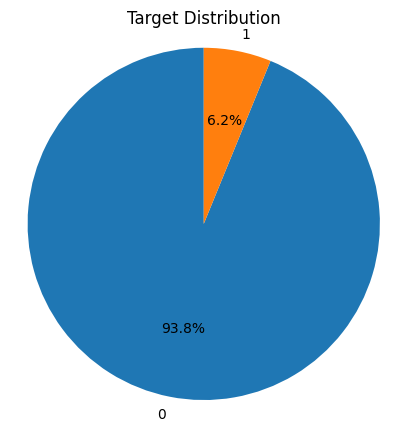

In [21]:
target_counts = df['target'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Target Distribution')
plt.show()

In [22]:
# Splitting the data
train_df, remaining = train_test_split(df, random_state=42, train_size=0.008, stratify=df.target.values)
valid_df, test_df = train_test_split(remaining, random_state=42, train_size=0.0008, stratify=remaining.target.values)
train_df.shape,valid_df.shape

((10448, 3), (1036, 3))

In [6]:
# BERT model from TensorFlow Hub
bert_model_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"
bert_layer = hub.KerasLayer(bert_model_url, trainable=True)

In [7]:
# BERT tokenizer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

In [28]:
def encode_text(text, max_len=128):
    tokens = tokenizer.tokenize(text.numpy().decode('utf-8'))
    tokens = tokens[:max_len-2]
    input_sequence = ["[CLS]"] + tokens + ["[SEP]"]
    pad_len = max_len - len(input_sequence)
    input_word_ids = tokenizer.convert_tokens_to_ids(input_sequence)
    input_word_ids += [0] * pad_len
    input_mask = [1] * len(input_sequence) + [0] * pad_len
    input_type_ids = [0] * max_len
    return np.array(input_word_ids), np.array(input_mask), np.array(input_type_ids)


def map_func(text, label):
    input_word_ids, input_mask, input_type_ids = tf.py_function(encode_text, inp=[text], Tout=(tf.int32, tf.int32, tf.int32))
    input_word_ids.set_shape([128])
    input_mask.set_shape([128])
    input_type_ids.set_shape([128])
    return {"input_word_ids": input_word_ids, "input_mask": input_mask, "input_type_ids": input_type_ids}, label

In [29]:
train_data = tf.data.Dataset.from_tensor_slices((train_df.question_text.values, train_df.target.values))
valid_data = tf.data.Dataset.from_tensor_slices((valid_df.question_text.values, valid_df.target.values))

In [30]:
train_data = train_data.map(map_func).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
valid_data = valid_data.map(map_func).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [31]:
# Model
input_word_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="input_mask")
input_type_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="input_type_ids")

inputs = {
    'input_word_ids': input_word_ids,
    'input_mask': input_mask,
    'input_type_ids': input_type_ids
}

bert_outputs = bert_layer(inputs)
sequence_output = bert_outputs['sequence_output']
clf_output = sequence_output[:, 0, :]
out = tf.keras.layers.Dense(1, activation='sigmoid')(clf_output)

model = tf.keras.models.Model(inputs=inputs, outputs=out)

In [32]:
# Optimizer with learning rate schedule
train_data_size = len(train_df)
epochs = 3
batch_size = 32
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)
optimizer = optimization.create_optimizer(init_lr=3e-5,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [35]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                            

In [34]:
# Training
history = model.fit(train_data, validation_data=valid_data, epochs=5, verbose=1)

Epoch 1/5
327/327 [==============================] - 305s 895ms/step - loss: 0.1727 - accuracy: 0.9432 - val_loss: 0.1077 - val_accuracy: 0.9575
Epoch 2/5
327/327 [==============================] - 291s 890ms/step - loss: 0.0889 - accuracy: 0.9678 - val_loss: 0.1203 - val_accuracy: 0.9595
Epoch 3/5
327/327 [==============================] - 290s 888ms/step - loss: 0.0420 - accuracy: 0.9857 - val_loss: 0.1276 - val_accuracy: 0.9604
Epoch 4/5
327/327 [==============================] - 290s 888ms/step - loss: 0.0235 - accuracy: 0.9935 - val_loss: 0.1276 - val_accuracy: 0.9604
Epoch 5/5
327/327 [==============================] - 290s 887ms/step - loss: 0.0229 - accuracy: 0.9932 - val_loss: 0.1276 - val_accuracy: 0.9604


## It has been determined that setting epoch = 3 yields the optimized performance for the model.

## Evaluating the Model

In [36]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

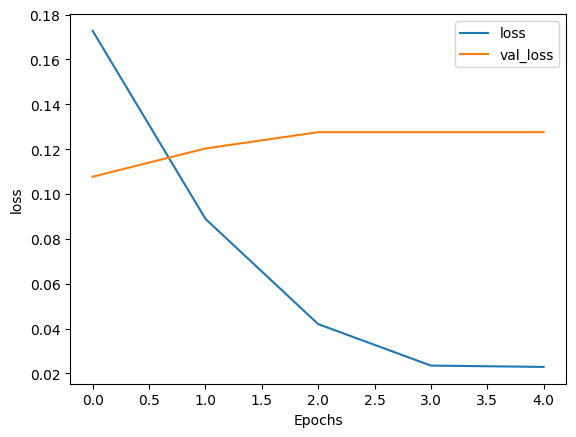

In [37]:
plot_graphs(history,'loss')

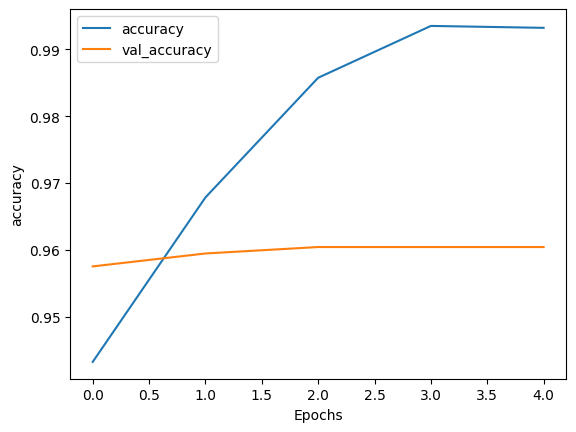

In [39]:
plot_graphs(history,'accuracy')

In [45]:
sample_example = ["Should I opt Jaypee University Guna for mechanical engineering?",\
                  "Why are Indians Brown?",\
                  "Can I get my home district as an IAS officer?",\
                  "What are some great books that explain the economics of digital businesses?",\
                  "Why is corrupt Kejriwal not allowing the centre to hike metro fares which will help in building new metros?
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
test_data = (test_data.map(map_func).batch(1))
preds = model.predict(test_data)

5/5 [==============================] - 0s 22ms/step


In [46]:
['Toxic' if pred >=0.5 else 'Sincere' for pred in preds]

['Sincere', 'Toxic', 'Sincere', 'Sincere', 'Toxic']

It seems to work pretty well ✌